<a href="https://colab.research.google.com/github/vmatiasw/modelos_y_simulacion/blob/main/P5E14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

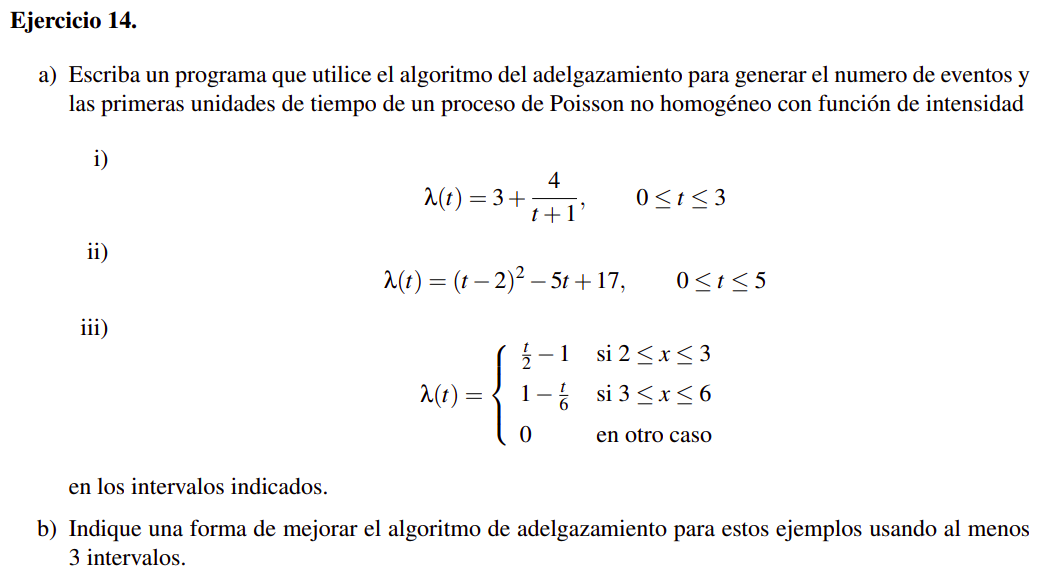

In [86]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def f_poisson(l, k): # l = l*t para homogeneo o m(s,t) para no homogeneo
    return np.exp(-l) * l**k / math.factorial(k)


## 8.a

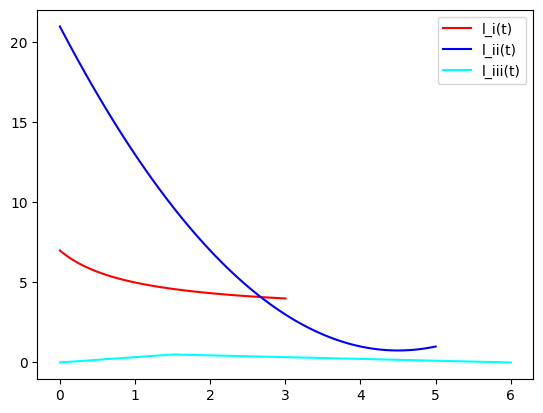

In [87]:
def l_i(t): # maximo: l_i(0)
  return np.where((0 <= t) & (t <= 3),
                  3 + 4 / (t + 1),
                  0)

def l_ii(t): # maximo: l_ii(0)
  return np.where((0 <= t) & (t <= 5),
                  (t-2)**2 - 5*t + 17,
                  0)

def l_iii(t): # maximo: l_iii(3)
  return np.where((2 <= t) & (t <= 3),
                  t/2 - 1,
                  np.where((3 <= t) & (t <= 6),
                           1 - t/6,
                           0))

#@title { vertical-output: true}
dom = lambda min, max: np.linspace(min, max, 100)
sns.lineplot(x=dom(0,3),   y=l_i(dom(0,3)), color='red', label='l_i(t)')
sns.lineplot(x=dom(0,5),  y=l_ii(dom(0,5)), color='blue', label='l_ii(t)')
sns.lineplot(x=dom(0,6), y=l_iii(dom(2,6)), color='aqua', label='l_iii(t)')
plt.legend()
plt.show()

In [88]:
def generar_tiempo_exponencial(tasa_lambda):
  return -np.log(1 - random()) / tasa_lambda

def generar_PPNH(func_intensidad, max_intensidad, tiempo_total):
  tiempos_eventos = []
  tiempo_acumulado = generar_tiempo_exponencial(max_intensidad)

  while tiempo_acumulado <= tiempo_total:
    if random() < func_intensidad(tiempo_acumulado) / max_intensidad:
      tiempos_eventos.append(tiempo_acumulado)

    tiempo_acumulado += generar_tiempo_exponencial(max_intensidad)

  return tiempos_eventos

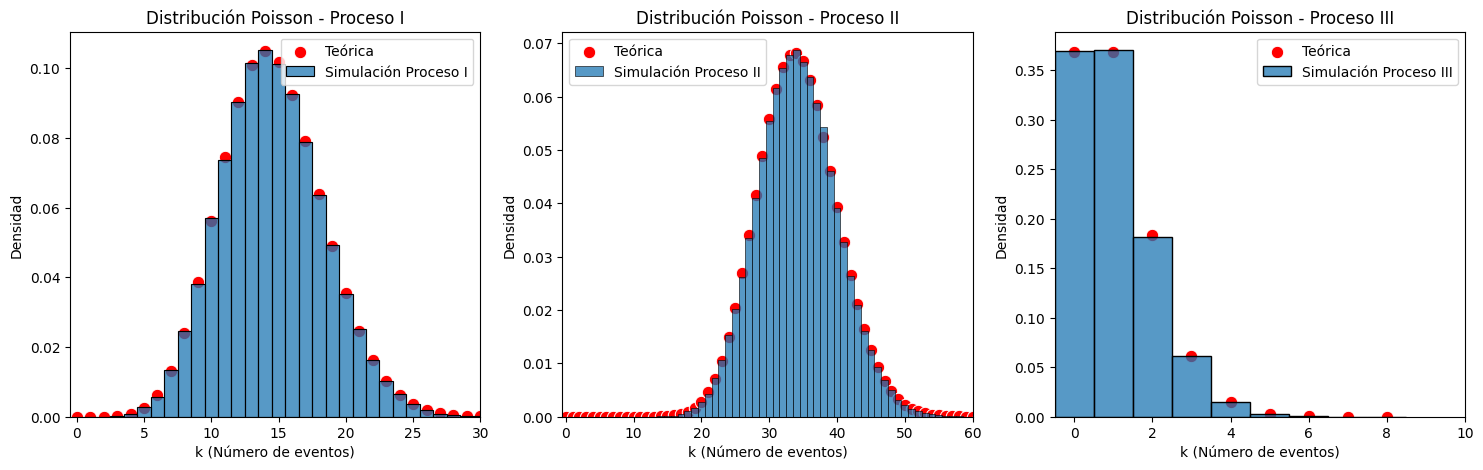

In [90]:
def graficar_simulaciones_poisson(procesos, generador_eventos, n_sim=10**5, limites=None, figsize=(18, 5)):
    n = len(procesos)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    if n == 1:
        axes = [axes]  # para casos con un solo proceso

    for idx, (nombre, lambda_teorica, *args) in enumerate(procesos):
        ax = axes[idx]
        generar = lambda: len(generador_eventos(*args))
        muestras = np.array([generar() for _ in range(n_sim)])

        dominio = np.arange(0, max(muestras) + 1)
        prob_teorica = [f_poisson(lambda_teorica, k) for k in dominio]

        sns.scatterplot(x=dominio, y=prob_teorica, color='red', label='Teórica', s=80, marker="o", ax=ax)
        sns.histplot(muestras, stat='density', label=f"Simulación {nombre}", discrete=True, ax=ax)

        if limites:
            ax.set_xlim(*limites[idx])
        ax.set_title(f'Distribución Poisson - {nombre}')
        ax.set_xlabel('k (Número de eventos)')
        ax.set_ylabel('Densidad')
        ax.legend()

PROCESOS = [
    ("Proceso I",9 + 4 * np.log(4), l_i, l_i(0), 3),
    ("Proceso II",205/6, l_ii, l_ii(0), 5),
    ("Proceso III",1, l_iii, l_iii(3), 7),
]
LIMITES = [(-0.5, 30), (-0.5, 60), (-0.5, 10)]

graficar_simulaciones_poisson(
    procesos=PROCESOS,
    generador_eventos=generar_PPNH,
    n_sim=10**5,
    limites=LIMITES
)

In [92]:
def estimar_llegadas(generador_eventos, procesos, n=1000):
    print('Número de llegadas estimado:')
    for idx, (nombre, lambda_teorica, *args) in enumerate(procesos):
        generar_eventos = lambda: generador_eventos(*args)
        numero_de_llegadas_estimado = sum([len(generar_eventos()) for _ in range(n)]) / n
        print(f"{nombre}: {numero_de_llegadas_estimado}")

estimar_llegadas(generar_PPNH, PROCESOS)

Número de llegadas estimado:
Proceso I: 14.576
Proceso II: 34.187
Proceso III: 1.028


## 8.b

In [93]:
def verificar_cotaintervalos(func_intensidad, tabla_tasa_tiempo, pasos=1000):
    """
    func_intensidad(t) ≤ λ_max ∀ λ_max, t ∈ tabla_tasa_tiempo
    """
    t_anterior = 0
    for l_max, t_lim in tabla_tasa_tiempo:
        for i in range(pasos):
            t = t_anterior + (t_lim - t_anterior) * i / pasos
            if func_intensidad(t) > l_max:
                print(f"Falla en t = {t:.4f}: λ(t) = {func_intensidad(t):.4f} > λ_max = {l_max}")
                return False
        t_anterior = t_lim
    return True

def Poisson_no_homogeneo_adelgazamiento(func_l, T, l):
    Eventos = []
    t = generar_tiempo_exponencial(l)
    while t <= T:
        V = random()
        if V < func_l(t) / l:
            Eventos.append(t)
        t += generar_tiempo_exponencial(l)
    return Eventos

def generar_PPNH_mejorado(func_intensidad, tabla_tasa_tiempo):
  eventos = []
  t_actual = generar_tiempo_exponencial(tabla_tasa_tiempo[0][0])

  for i, (l_max, t_lim) in enumerate(tabla_tasa_tiempo):
    while t_actual <= t_lim:
        if random() < func_intensidad(t_actual) / l_max:
          eventos.append(t_actual)
        t_actual += generar_tiempo_exponencial(l_max)

    if i + 1 == len(tabla_tasa_tiempo): break
    t_actual = t_lim + (t_actual - t_lim) * (l_max / tabla_tasa_tiempo[i+1][0])

  return eventos

In [106]:
# Revision
PROCESOS_MEJORADO = [
    ("Proceso I", 9 + 4 * np.log(4), l_i, [(l_i(0), 1), (l_i(1), 2), (l_i(2), 3)]),
    ("Proceso II", 205/6, l_ii, [(l_ii(0), 2), (l_ii(2), 4.5), (l_ii(5), 5)]),
    ("Proceso III", 1, l_iii, [(l_iii(3), 4), (l_iii(4), 5), (l_iii(5), 6)]),
]
estimar_llegadas(generar_PPNH_mejorado, PROCESOS_MEJORADO)

Número de llegadas estimado:
Proceso I: 15.014
Proceso II: 35.449
Proceso III: 1.218

Número de llegadas estimado:
Proceso I: 14.477
Proceso II: 34.331
Proceso III: 0.955


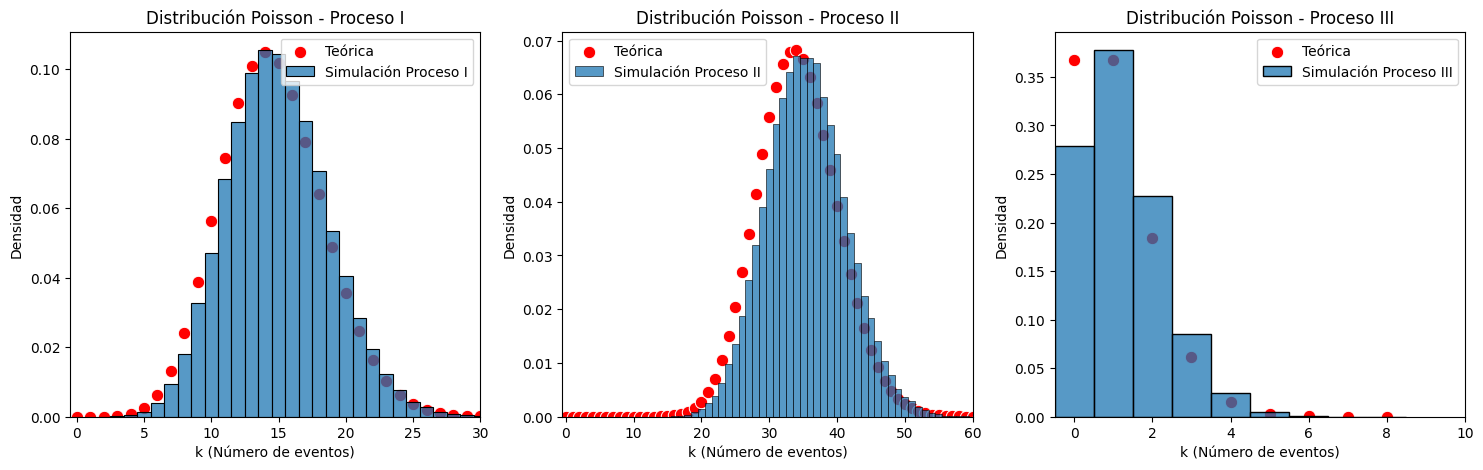

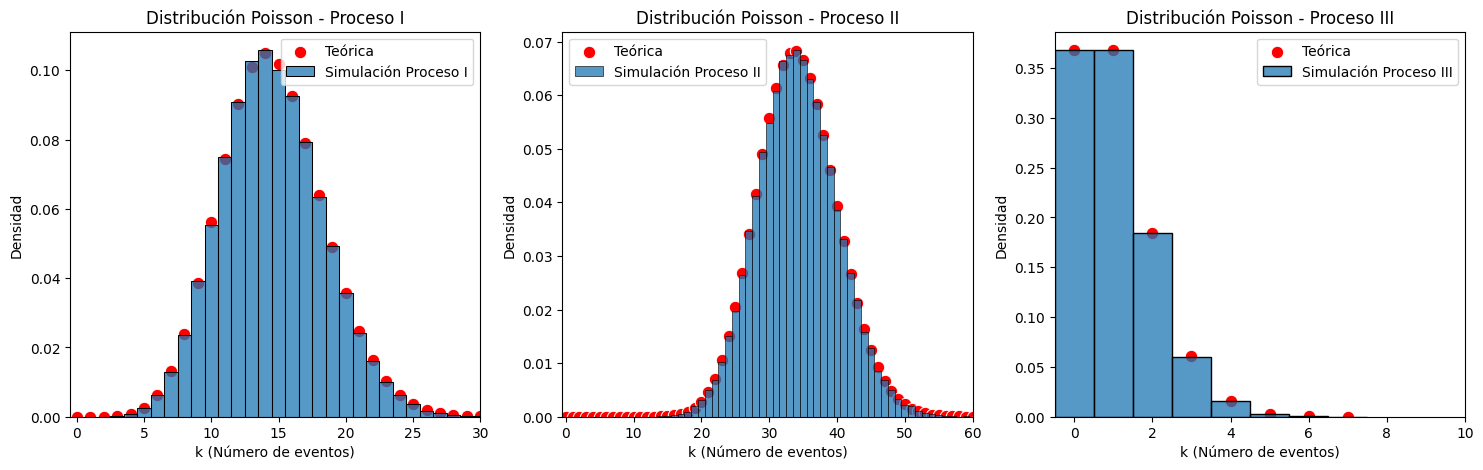

In [107]:
graficar_simulaciones_poisson(
    procesos=PROCESOS_MEJORADO,
    generador_eventos=generar_PPNH_mejorado,
    n_sim=10**5,
    limites=LIMITES
)

In [96]:
# ------------------------------------------ i)
%%timeit
generar_PPNH(l_i, l_i(0), 3)

200 µs ± 7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [97]:
%%timeit
generar_PPNH_mejorado(l_i, [(l_i(0), 1), (l_i(1), 2), (l_i(2), 3)])

187 µs ± 42.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [99]:
# ------------------------------------------ ii)
%%timeit
generar_PPNH(l_ii, l_ii(0), 5)

1.43 ms ± 527 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [100]:
%%timeit
generar_PPNH_mejorado(l_ii, [(l_ii(0), 2), (l_ii(2), 4.5), (l_ii(5), 5)])

707 µs ± 144 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [102]:
# ------------------------------------------ iii)
%%timeit
generar_PPNH(l_iii, l_iii(3), 7)

53.4 µs ± 791 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [103]:
%%timeit
generar_PPNH_mejorado(l_ii, [(l_iii(3), 4), (l_iii(4), 5), (l_iii(5), 6)])

68.5 µs ± 16.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Curiosidad, que sucede si se mejora mal

### ✅ Versión correcta (con ajuste de salto entre tramos)
```python
def generar_PPNH_mejorado(func_intensidad, tabla_tasa_tiempo):
  eventos = []
  t_actual = generar_tiempo_exponencial(tabla_tasa_tiempo[0][0])

  for i, (l_max, t_lim) in enumerate(tabla_tasa_tiempo):
    while t_actual <= t_lim:
        if random() < func_intensidad(t_actual) / l_max:
          eventos.append(t_actual)
        t_actual += generar_tiempo_exponencial(l_max)
    
    if i + 1 == len(tabla_tasa_tiempo): break
    t_actual = t_lim + (t_actual - t_lim) * (l_max / tabla_tasa_tiempo[i+1][0])

  return eventos
```
### ❌ Versión incorrecta (sin ajuste de salto)
```python
def generar_PPNH_mejorado_mal(func_intensidad, tabla_tasa_tiempo):
  eventos = []
  t_actual = generar_tiempo_exponencial(tabla_tasa_tiempo[0][0])

  for l_max, t_lim in tabla_tasa_tiempo:
    while t_actual <= t_lim:
        if random() < func_intensidad(t_actual) / l_max:
          eventos.append(t_actual)
        t_actual += generar_tiempo_exponencial(l_max)

  return eventos
```
Ya que no se ajusto el salto. No se puede eliminar ningun evento si no es por adelgazamiento, cambia la probabilidad y por lo tanto la distribucion.

### Chargpteado:

#### ⚠️ Justificación técnica
La versión incorrecta omite un paso esencial al cambiar la tasa máxima λ_max: no ajusta el tiempo restante del proceso base, lo cual viola la distribución exponencial de los tiempos de espera del proceso homogéneo utilizado como base.

Cuando cambiamos la tasa λ_max de un proceso de Poisson homogéneo usado en el método de adelgazamiento, no podemos simplemente continuar generando tiempos exponenciales con la nueva tasa sin ajustar la posición temporal. Esto equivale a eliminar o acortar artificialmente eventos, lo que altera la probabilidad de aceptación y, por lo tanto, modifica la distribución del proceso simulado.

👉 **En otras palabras**: los únicos eventos que pueden ser descartados son aquellos rechazados explícitamente por adelgazamiento (thinning), no por un mal manejo del cambio de tasa.

El ajuste:`t_actual = t_lim + (t_actual - t_lim) * (l_max / siguiente_l_max)` compensa el "tiempo residual" para que conserve la memoria de la distribución exponencial original, respetando así el modelo del proceso Poisson no homogéneo.

#### 📎 Conexión teórica
La distribución exponencial tiene la propiedad de falta de memoria (memorylessness), pero eso solo aplica si se mantiene constante la tasa λ. Si esta cambia, debemos recalcular el tiempo residual correctamente.

Este método proviene del algoritmo de adelgazamiento de Lewis-Shedler, ajustado para intensidades por tramos.

Abajo podemos ver como quedaria si lo hacemos mal:

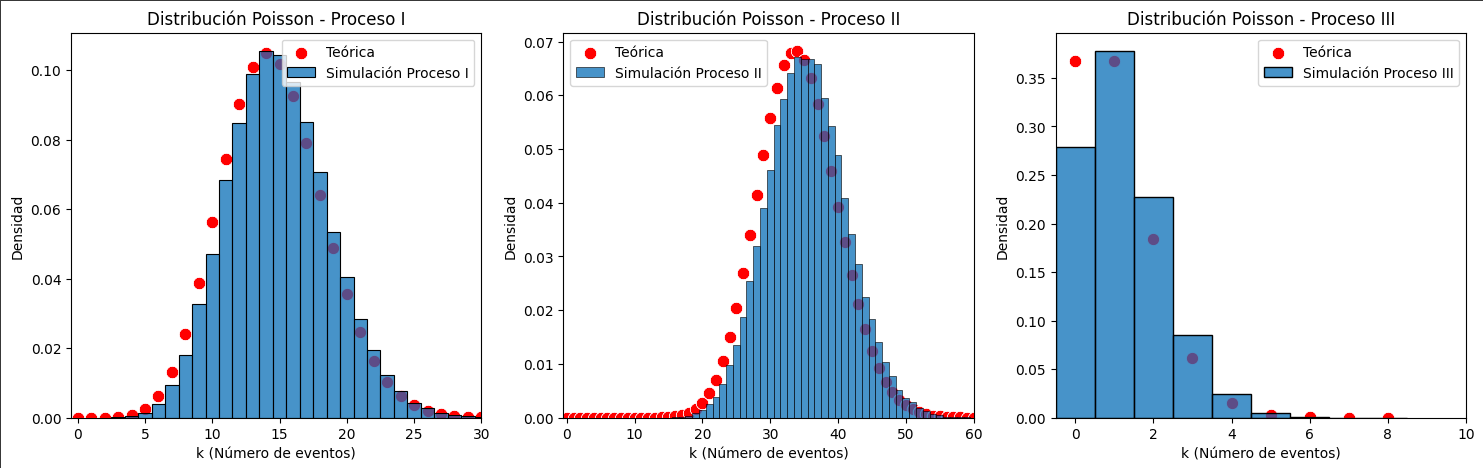